
📊 Model Evaluation Results:

Linear Regression:
  RMSE: 0.0203
  MAE: 0.0132
  R2: 0.9993

Random Forest:
  RMSE: 0.0209
  MAE: 0.0128
  R2: 0.9992

Gradient Boosting:
  RMSE: 0.0246
  MAE: 0.0167
  R2: 0.9989


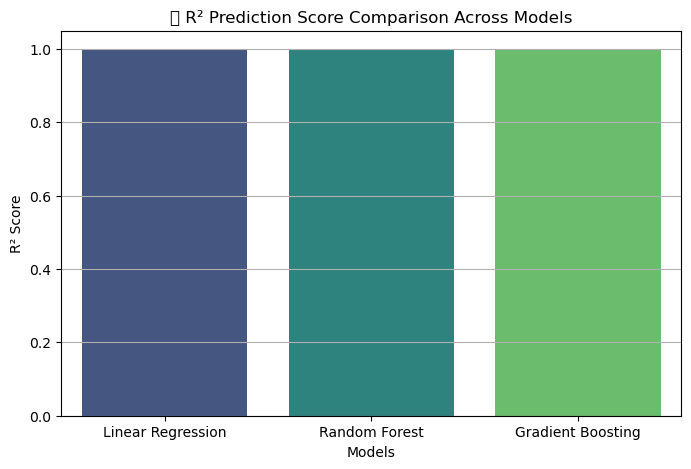

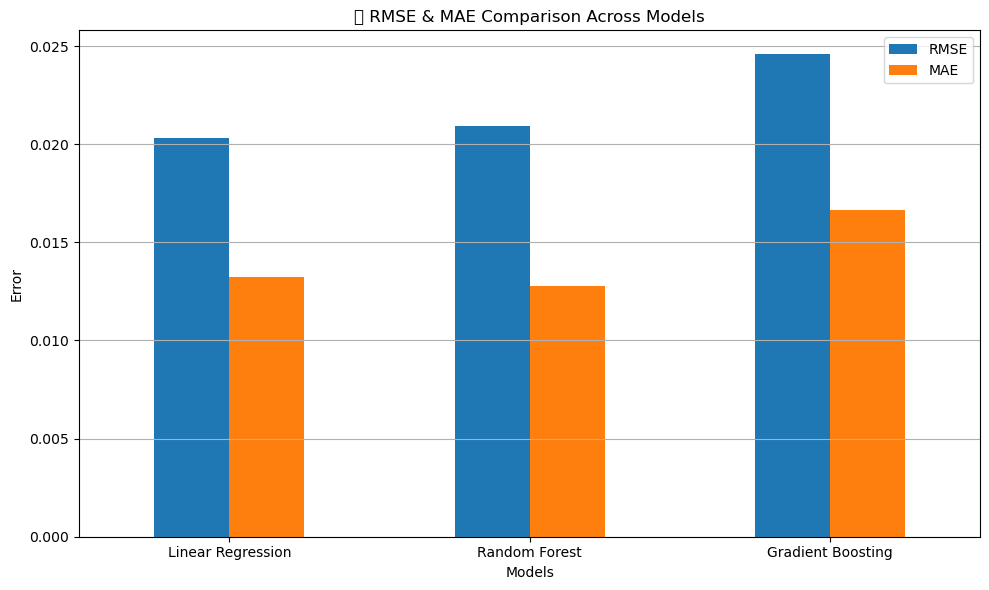

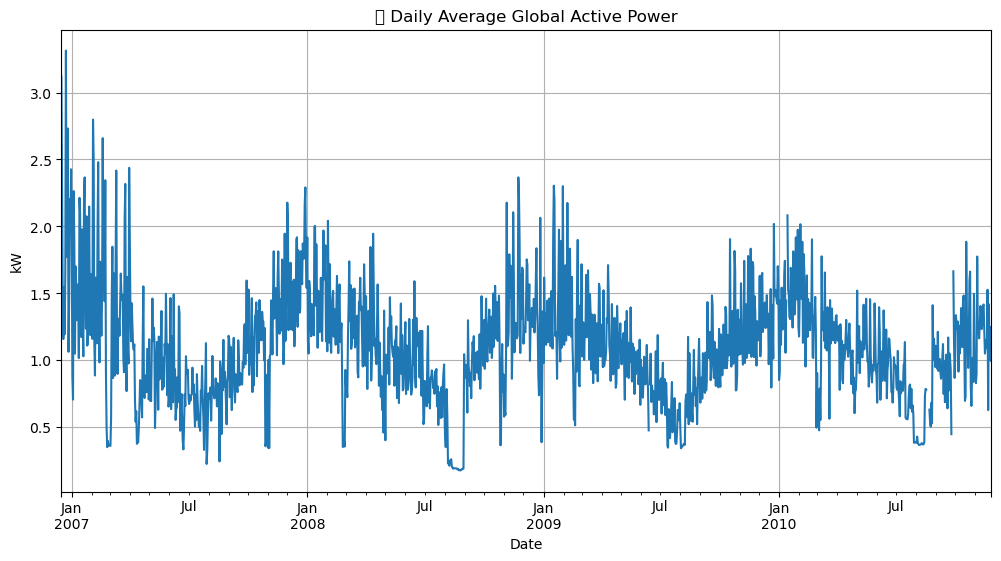

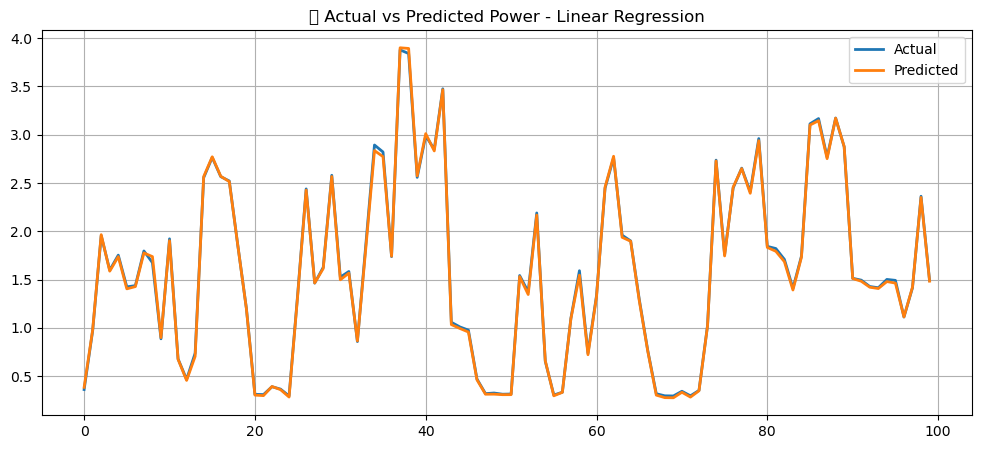

In [3]:
# PowerPulse: Optimized Household Energy Usage Forecast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Step 1: Load and Preprocess Data
file_path = 'household_power_consumption.txt'

df = pd.read_csv(file_path, sep=';', parse_dates=[[0, 1]], infer_datetime_format=True,
                 na_values='?', low_memory=False)
df.columns = ['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 
              'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Convert to numeric
df = df.apply(pd.to_numeric)

# Step 2: Resample to Hourly Data
df_hourly = df.resample('H').mean().dropna()

# Step 3: Feature Engineering
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.day
df_hourly['weekday'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = df_hourly['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df_hourly['month'] = df_hourly.index.month
df_hourly['rolling_mean_3h'] = df_hourly['Global_active_power'].rolling(window=3, min_periods=1).mean()
df_hourly['lag_1'] = df_hourly['Global_active_power'].shift(1).fillna(method='bfill')

# Step 4: Train-Test Split
features = ['Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'hour', 'day', 'weekday', 'is_weekend', 'month',
            'rolling_mean_3h', 'lag_1']

X = df_hourly[features]
y = df_hourly['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Define and Train Models
models = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42))
    ])
}

results = {}
predictions = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred
    results[name] = {
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Step 6: Display Evaluation Results
print("\n📊 Model Evaluation Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Step 6.1: Visualize Prediction Scores (R²) for All Models
r2_scores = {name: metrics['R2'] for name, metrics in results.items()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), palette='viridis')
plt.ylim(0, 1.05)
plt.title('📊 R² Prediction Score Comparison Across Models')
plt.ylabel('R² Score')
plt.xlabel('Models')
plt.grid(True, axis='y')
plt.show()

# Step 6.2: RMSE and MAE Comparison Bar Chart
metrics_df = pd.DataFrame(results).T[['RMSE', 'MAE']]
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('📊 RMSE & MAE Comparison Across Models')
plt.ylabel('Error')
plt.xlabel('Models')
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 7: Visualization - Daily Average Power
plt.figure(figsize=(12, 6))
df_hourly['Global_active_power'].resample('D').mean().plot()
plt.title('📈 Daily Average Global Active Power')
plt.ylabel('kW')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Step 8: Actual vs Predicted Plot (Best Model)
best_model_name = min(results.items(), key=lambda x: x[1]['RMSE'])[0]
best_pipeline = models[best_model_name]
y_pred_best = predictions[best_model_name]

plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred_best[:100], label='Predicted', linewidth=2)
plt.title(f'🔍 Actual vs Predicted Power - {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Feature Importance (for Tree Models Only)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    model_core = best_pipeline.named_steps['model']
    importances = model_core.feature_importances_
    feat_imp = pd.Series(importances, index=features)
    feat_imp.nlargest(10).plot(kind='barh', figsize=(10, 5), color='teal')
    plt.title(f'🎯 {best_model_name} - Top 10 Feature Importances')
    plt.xlabel('Importance Score')
    plt.grid(True)
    plt.show()
